# Going beyond galaxy as tracer with `halomod`

`halomod` is written in a way that is most native to applications of halo models of galaxies. Therefore, modifications and extensions in the context of galaxy clustering (as well as HI assuming HI is trivially related to galaxies) are very straightforward. However, it may not be as straightforward when dealing with other tracers. In this tutorial, we use the flux density power spectrum of 0906.3020 to demonstrate fully utilise the flexibility of `halomod`.

The flux density power spectrum can modelled as (see Sec 2.3 of 0906.3020):
$$
P_{1h}(k) = |u_J(k)|^2 \int_{M_{\rm min}}^{\infty} {\rm d}m\, n(m) \bigg(\frac{m}{\bar{\rho}_{\rm gal}}\bigg)^2
$$

$$
P_{2h}(k)=|u_J(k)|^2\bigg[\int_{M_{\rm min}}^{\infty}{\rm d}m\,n(m)b(m)\Big(\frac{m}{\bar{\rho}_{\rm gal}}\Big)\bigg]^2 P_{\rm lin}(k)
$$

where $u_J(k)={\rm arctan}(k\lambda_{\rm mfp})/(k\lambda_{\rm mfp})$

## HOD
Once we have the expression of power spectrum we want, we should try to identify the halo model components. Comparing it to the standard halo model formalism, it's easy to see that it effectively means:
$$
\langle M_{\rm cen}\rangle \equiv 0
$$

$$
\langle M_{\rm sat}\rangle \equiv A
$$

where $A_{\rm sat}$ is a constant so that the total satellite occupation is equal to the mean mass density of galaxies:

$$
\int_{M_{\rm min}} {\rm d}m\, n(m)A = \bar{\rho}_{\rm gal}
$$

This HOD has already been defined by `Constant` hod class:

In [1]:
from halomod import TracerHaloModel
import numpy as np
from matplotlib import pyplot as plt

In [2]:
hm = TracerHaloModel(hod_model="Constant")

In [3]:
hm.central_occupation

0

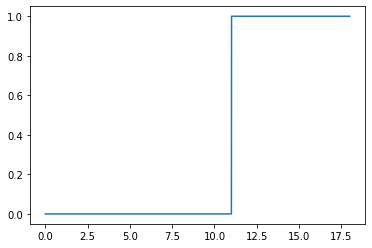

In [4]:
plt.plot(np.log10(hm.m),hm.satellite_occupation)

## Density Profile

The density profile is already included as `PowerLawWithExpCut`:

$$
\rho(r) = \rho_s \big(r/r_s \big)^{-b}{\rm exp}\big[-a r/r_s\big]
$$

and in this specific case we have $b=2$.

However, the native way of defining density profile in `halomod` is to relate it to the characteristic scale $r_s$, which is related to the concentration parameter. Therefore, for each halo of different mass the shape of the density profile is different. But in this case we want to keep the shape of the profile the same for all halos. Although `halomod` does not provide a readily available solution, note:

$$
m \sim r_s^3c^3(m,z)
$$

$$
r_s \sim m^{1/3}c^{-1}(m,z)
$$

Therefore, we only need to define a special concentration-mass relation to keep $r_s$ constant. Suppose we construct a C-M relation:

In [5]:
from halomod.concentration import CMRelation
from hmf.halos.mass_definitions import SOMean

In [6]:
class cmflux(CMRelation):
    _defaults = {'c_0': 4}
    native_mdefs = (SOMean(),)

    def cm(self,m,z):
        return self.params['c_0']*(m*10**(-11))**(1/3)

In [7]:
hm = TracerHaloModel(halo_concentration_model = cmflux,
                    halo_profile_model = "PowerLawWithExpCut",
                    halo_profile_params = {"b":2.0,"a":1.0},
                    hod_model = "Constant")

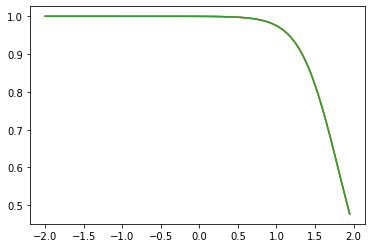

In [8]:
plt.plot(np.log10(hm.k_hm),hm.tracer_profile.u(hm.k_hm,m=1e12))
plt.plot(np.log10(hm.k_hm),hm.tracer_profile.u(hm.k_hm,m=1e13))
plt.plot(np.log10(hm.k_hm),hm.tracer_profile.u(hm.k_hm,m=1e14))

One can see that indeed the density profile is now independant of halo mass

## Tuning parameters

So far the parameters are randomly set without clear physical meanings. We can easily tune these parameters to desired physical values.

Suppose we want the mass density of galaxies to be $10^{-2}$ of the total critical density:

In [9]:
rhoc = hm.cosmo.critical_density0.to("Msun/Mpc^3").value*hm.cosmo.h**2

In [10]:
hm.mean_tracer_den/rhoc

6.33430035931596e-13

That means the parameter `logA` for hod should be changed to:

In [11]:
-np.log10(hm.mean_tracer_den/rhoc)

12.198301347137022

In [12]:
hm.hod_params = {"logA":-np.log10(hm.mean_tracer_den/rhoc)}

In [13]:
hm.mean_tracer_den/rhoc

1.0000000000000016

The density profile should satisfy $r_s/a = \lambda_{\rm mfp}$. $r_s$ can be obtained as:

In [14]:
rs = hm.halo_profile.halo_mass_to_radius(1e11)/hm.halo_concentration.cm(1e11,z=0)
print(rs)

0.027958379670079817


In [15]:
hm.halo_profile.halo_mass_to_radius(1e12)/hm.halo_concentration.cm(1e12,z=0)

0.027958379670079813

in the units of Mpc/h. Assume we want $\lambda_{\rm mfp} = 10$Mpc/h:

In [16]:
hm.halo_profile_params = {"a":rs/10}

Check the density profile to see the cut-off:

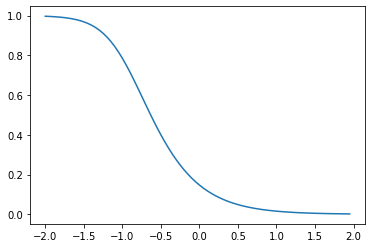

In [17]:
plt.plot(np.log10(hm.k_hm),hm.tracer_profile.u(hm.k_hm,m=1e12))

You can see it's indeed around 0.1 Mpc$^{-1}$h

Finally we can see the power spectrum:

In [18]:
hm.power_1h_cs_auto_tracer

/home/ztchen/work/gitproject/halomod/src/halomod/halo_model.py:1285: RuntimeWarning: overflow encountered in double_scalars
  c[i] = tools.spline_integral(self.m, intg, xmin=10 ** mmin)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

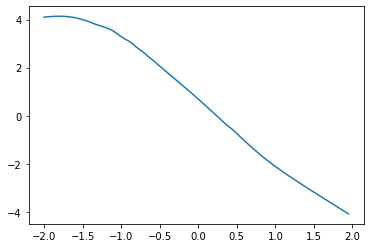

In [19]:
plt.plot(np.log10(hm.k_hm),np.log10(hm.power_auto_tracer))